In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import sqlite3 as sql


In [2]:
sys.path.append('/groups/icecube/cyan/Utils')
from PlotUtils import setMplParam, getColour, getHistoParam 
# getHistoParam:
# Nbins, binwidth, bins, counts, bin_centers  = 
from DB_lister import list_content, list_tables
from ExternalFunctions import nice_string_output, add_text_to_ax
setMplParam()

In [24]:
dir_pulsemap_22012_part_1 = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/sqlite_pulses/Snowstorm/22012/merged_part_1.db"
dir_pulsemap_22012_part_14 = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/sqlite_pulses/Snowstorm/22012/merged_part_14.db"
source_root = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/sqlite_pulses/Snowstorm/"

In [22]:
source_root = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/sqlite_pulses/Snowstorm/"
subdirectory_name=22012
source_dir = os.path.join(source_root, str(subdirectory_name))
# first file in the destination root is used to obtain the truth table name
first_db_file = next((f for f in os.listdir(source_dir) if f.endswith('.db')), None)

In [23]:
first_db_file

'merged_part_14.db'

In [26]:
list_tables(dir_pulsemap_22012_part_14)

['truth', 'SRTInIcePulses', 'event_no_SRTInIcePulses', 'OnlineL2_SplineMPE', 'LineFit', 'GNHighestEInIceParticle', 'GNHighestEDaughter', 'MCWeightDict', 'SnowStormParameters', 'FilterMask', 'idx_event_no', 'idx_dom_position', 'idx_string_dom_number']


In [4]:
list_tables(dir_pulsemap_22012_part_1)

['truth', 'SRTInIcePulses', 'event_no_SRTInIcePulses', 'OnlineL2_SplineMPE', 'LineFit', 'GNHighestEInIceParticle', 'GNHighestEDaughter', 'MCWeightDict', 'SnowStormParameters', 'FilterMask', 'idx_event_no', 'idx_dom_position', 'idx_string_dom_number']


In [5]:
def convertDBtoDF(file:str, table:str, N_events:int = None) -> pd.DataFrame:
    con = sql.connect(file)
    event_no_query = f'SELECT DISTINCT event_no FROM {table}'
    event_nos = pd.read_sql_query(event_no_query, con)['event_no'].tolist()
    event_filter = ','.join(map(str, event_nos))
    query = f'SELECT * FROM {table} WHERE event_no IN ({event_filter})'
    df = pd.read_sql_query(query, con)
    con.close()
    return df

In [6]:
df_snowstorm_22012_part_1_truth = convertDBtoDF(dir_pulsemap_22012_part_1,'truth')
df_snowstorm_22012_part_1_GN_daughter = convertDBtoDF(dir_pulsemap_22012_part_1,'GNHighestEDaughter')

In [7]:
def add_horizontal_distance(df:pd.DataFrame) -> pd.DataFrame:
    df['position_r'] = np.sqrt(df['position_x']**2 + df['position_y']**2)
    return df

In [8]:
def add_is_interior(df: pd.DataFrame) -> pd.DataFrame:
    df['is_interior'] = (df['position_r'] < 2500) & (-2500 < df['position_z']) & (df['position_z'] < 2500)
    return df

In [9]:
def process(df:pd.DataFrame) -> pd.DataFrame:
    df = add_horizontal_distance(df)
    df = add_is_interior(df)
    return df

In [10]:
df_snowstorm_22012_part_1_GN_daughter

,zenith_GNHighestEDaughter,azimuth_GNHighestEDaughter,dir_x_GNHighestEDaughter,dir_y_GNHighestEDaughter,dir_z_GNHighestEDaughter,pos_x_GNHighestEDaughter,pos_y_GNHighestEDaughter,pos_z_GNHighestEDaughter,time_GNHighestEDaughter,speed_GNHighestEDaughter,energy_GNHighestEDaughter,event_no
0,0.917287,5.843878,-0.718566,0.337679,-0.607976,3.445443e+02,-1.089283e+03,1.865997e+03,1.442161e+04,NaN,4.096293e+06,0
1,1.708568,5.431356,-0.652367,0.745356,0.137336,9.232024e+05,-1.055929e+06,-1.944417e+05,-4.714971e+06,NaN,2.661785e+06,1
2,0.965347,2.869426,0.791980,-0.221036,-0.569132,-2.099700e+03,1.842814e+02,1.940235e+03,1.415223e+03,0.299792,1.510685e+07,2
3,0.480437,5.131131,-0.187923,0.422236,-0.886793,-2.540791e+02,-4.978084e+02,-4.825141e+02,9.765365e+03,0.299792,6.363587e+06,3
4,0.921205,0.912672,-0.487063,-0.630010,-0.604861,1.381710e+03,2.362207e+03,1.248658e+03,1.560761e+02,0.299792,8.082681e+07,4
...,...,...,...,...,...,...,...,...,...,...,...,...
29381,0.611197,2.746217,0.529577,-0.221020,-0.818962,-4.979710e+02,-1.398958e+01,1.303447e+03,6.325305e+03,0.299792,4.508128e+06,29381
29382,0.925723,0.573129,-0.671373,-0.433299,-0.601257,5.693709e+02,9.056359e+02,3.008085e+02,7.033463e+03,0.299792,3.621763e+06,29382
29383,0.844400,3.501743,0.699611,0.263455,-0.664180,4.157779e+02,-2.490632e+02,-6.817077e+02,1.277263e+04,NaN,6.579279e+05,29383
29384,2.612760,2.180361,0.288846,-0.413660,0.863396,-2.471008e+06,3.537997e+06,-7.384847e+06,-2.851966e+07,NaN,7.996037e+05,29384


In [11]:
df_snowstorm_22012_part_1_GN_daughter.columns

Index(['zenith_GNHighestEDaughter', 'azimuth_GNHighestEDaughter',
       'dir_x_GNHighestEDaughter', 'dir_y_GNHighestEDaughter',
       'dir_z_GNHighestEDaughter', 'pos_x_GNHighestEDaughter',
       'pos_y_GNHighestEDaughter', 'pos_z_GNHighestEDaughter',
       'time_GNHighestEDaughter', 'speed_GNHighestEDaughter',
       'energy_GNHighestEDaughter', 'event_no'],
      dtype='object')

In [12]:
df_snowstorm_22012_part_1_GN_daughter[['pos_x_GNHighestEDaughter', 'pos_y_GNHighestEDaughter', 'pos_z_GNHighestEDaughter']].describe()

,pos_x_GNHighestEDaughter,pos_y_GNHighestEDaughter,pos_z_GNHighestEDaughter
count,2.938600e+04,2.938600e+04,2.938600e+04
mean,-8.476124e+03,-3.133727e+03,-8.553222e+05
std,1.295807e+06,1.309237e+06,2.305242e+06
min,-6.286715e+06,-6.298374e+06,-1.264811e+07
25%,-1.112786e+03,-1.093493e+03,-6.832585e+02
50%,-7.380807e+00,-1.041752e+01,2.462763e+02
75%,1.058177e+03,1.061863e+03,9.924946e+02
max,6.313005e+06,6.280057e+06,1.947945e+03


In [13]:
df_snowstorm_22012_part_1_truth.columns

Index(['energy', 'position_x', 'position_y', 'position_z', 'azimuth', 'zenith',
       'pid', 'event_time', 'interaction_type', 'elasticity', 'RunID',
       'SubrunID', 'EventID', 'SubEventID', 'dbang_decay_length',
       'track_length', 'stopped_muon', 'energy_track', 'energy_cascade',
       'inelasticity', 'DeepCoreFilter_13', 'CascadeFilter_13',
       'MuonFilter_13', 'OnlineL2Filter_17', 'L3_oscNext_bool',
       'L4_oscNext_bool', 'L5_oscNext_bool', 'L6_oscNext_bool',
       'L7_oscNext_bool', 'Homogenized_QTot', 'MCLabelClassification',
       'MCLabelCoincidentMuons', 'MCLabelBgMuonMCPE',
       'MCLabelBgMuonMCPECharge', 'GNLabelTrackEnergyDeposited',
       'GNLabelTrackEnergyOnEntrance', 'GNLabelTrackEnergyOnEntrancePrimary',
       'GNLabelTrackEnergyDepositedPrimary', 'GNLabelEnergyPrimary',
       'GNLabelCascadeEnergyDepositedPrimary', 'GNLabelCascadeEnergyDeposited',
       'GNLabelEnergyDepositedTotal', 'GNLabelEnergyDepositedPrimary',
       'GNLabelHighestEInIcePa

In [14]:
df_snowstorm_22012_part_1_truth

,energy,position_x,position_y,position_z,azimuth,zenith,pid,event_time,interaction_type,elasticity,...,GNLabelCascadeEnergyDeposited,GNLabelEnergyDepositedTotal,GNLabelEnergyDepositedPrimary,GNLabelHighestEInIceParticleIsChild,GNLabelHighestEInIceParticleDistance,GNLabelHighestEInIceParticleEFraction,GNLabelHighestEInIceParticleEOnEntrance,GNLabelHighestEDaughterDistance,GNLabelHighestEDaughterEFraction,event_no
0,8.238094e+06,4.413257e+02,-1.134763e+03,1.947884e+03,5.843885,0.917283,-14.0,1.306125e+17,2.0,-1.0,...,0.000000,7.705485e+02,0.000000e+00,0.0,270.651789,0.000343,1.803995e+03,2.187965e+03,0.497238,0
1,5.375572e+07,1.150305e+06,-1.315402e+06,-2.422512e+05,5.431356,1.708568,14.0,1.306125e+17,1.0,-1.0,...,0.000000,0.000000e+00,0.000000e+00,0.0,756.651768,0.802005,4.311235e+07,1.416014e+06,0.049516,1
2,2.576900e+07,-2.110016e+03,1.871605e+02,1.947648e+03,2.869423,0.965348,14.0,1.306125e+17,1.0,-1.0,...,0.000000,2.350936e+05,2.350831e+05,1.0,568.238274,0.586241,8.593191e+06,5.682383e+02,0.586241,2
3,6.547825e+06,2.609275e+02,-1.654963e+03,1.947780e+03,5.131130,0.480436,14.0,1.306125e+17,1.0,-1.0,...,184238.112305,2.236012e+05,2.235506e+05,1.0,738.369268,0.971863,6.363587e+06,7.383693e+02,0.971863,3
4,8.446194e+07,1.944014e+03,3.089538e+03,1.946955e+03,0.912671,0.921206,14.0,1.306125e+17,1.0,-1.0,...,0.000000,0.000000e+00,0.000000e+00,1.0,736.585870,0.956961,4.219100e+07,7.365859e+02,0.956961,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29381,6.344052e+06,-9.147304e+02,1.599477e+02,1.947932e+03,2.746214,0.611205,-14.0,1.306125e+17,1.0,-1.0,...,0.000000,7.600000e+04,7.600000e+04,1.0,428.144576,0.710607,1.369816e+06,4.281446e+02,0.710607,29381
29382,4.438849e+06,2.407730e+03,2.092120e+03,1.947202e+03,0.573137,0.925718,-14.0,1.306125e+17,1.0,-1.0,...,0.000000,2.298693e+04,2.287407e+04,1.0,567.273615,0.815924,3.481434e+06,5.672736e+02,0.815924,29382
29383,1.867177e+07,-2.352021e+03,-1.292281e+03,1.947435e+03,3.502039,0.844169,14.0,1.306125e+17,2.0,-1.0,...,0.000000,0.000000e+00,0.000000e+00,1.0,836.438397,0.035236,6.579279e+05,8.364384e+02,0.035236,29383
29384,1.297350e+07,-3.179350e+06,4.552421e+06,-9.502167e+06,2.180361,2.612760,14.0,1.306125e+17,1.0,-1.0,...,0.000000,2.284465e+02,2.284465e+02,0.0,447.438123,0.003948,2.002971e+03,8.553319e+06,0.061634,29384


In [15]:
df_snowstorm_22012_part_1_truth = process(df_snowstorm_22012_part_1_truth)

In [16]:
def plot_pos_distribution(pos_x, pos_y, pos_z):
    fig_x, ax_x = plt.subplots(figsize=(10, 6))
    ax_x.hist(pos_x, bins=100, histtype='step', label='x')
    ax_x.set_xlabel('x [m]')
    ax_x.set_ylabel('Counts')
    ax_x.set_yscale('log')
    ax_x.legend()
    
    fig_y, ax_y = plt.subplots(figsize=(10, 6))
    ax_y.hist(pos_y, bins=100, histtype='step', label='y', color = getColour(1))
    ax_y.set_xlabel('y [m]')
    ax_y.set_ylabel('Counts')
    ax_y.set_yscale('log')
    ax_y.legend()
    
    fig_z, ax_z = plt.subplots(figsize=(10, 6))
    ax_z.hist(pos_z, bins=100, histtype='step', label='z', color = getColour(2))
    ax_z.set_xlabel('z [m]')
    ax_z.set_ylabel('Counts')
    ax_z.set_yscale('log')
    
    

In [17]:
pos_x = df_snowstorm_22012_part_1_GN_daughter['pos_x_GNHighestEDaughter'][df_snowstorm_22012_part_1_GN_daughter['pos_x_GNHighestEDaughter'].abs() < 5000]
pos_y = df_snowstorm_22012_part_1_GN_daughter['pos_y_GNHighestEDaughter'][df_snowstorm_22012_part_1_GN_daughter['pos_y_GNHighestEDaughter'].abs() < 5000]
pos_z = df_snowstorm_22012_part_1_GN_daughter['pos_z_GNHighestEDaughter'][df_snowstorm_22012_part_1_GN_daughter['pos_z_GNHighestEDaughter'].abs() < 5000]

In [18]:
print(f"frac within 5000m for x {pos_x.shape[0]/df_snowstorm_22012_part_1_GN_daughter['pos_x_GNHighestEDaughter'].shape[0]}")
print(f"frac within 5000m for y {pos_y.shape[0]/df_snowstorm_22012_part_1_GN_daughter['pos_y_GNHighestEDaughter'].shape[0]}")
print(f"frac within 5000m for z {pos_z.shape[0]/df_snowstorm_22012_part_1_GN_daughter['pos_z_GNHighestEDaughter'].shape[0]}")

frac within 5000m for x 0.7248689852310624
frac within 5000m for y 0.7233376437759478
frac within 5000m for z 0.7928945756482679


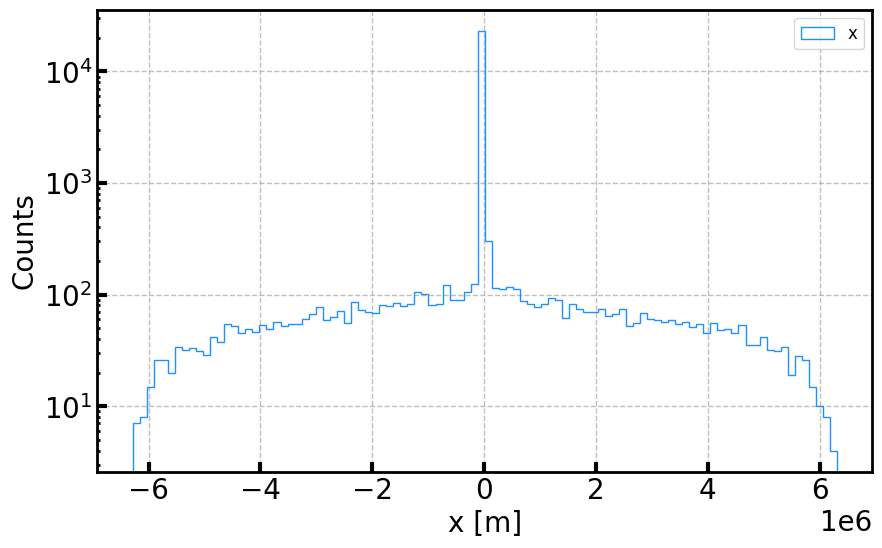

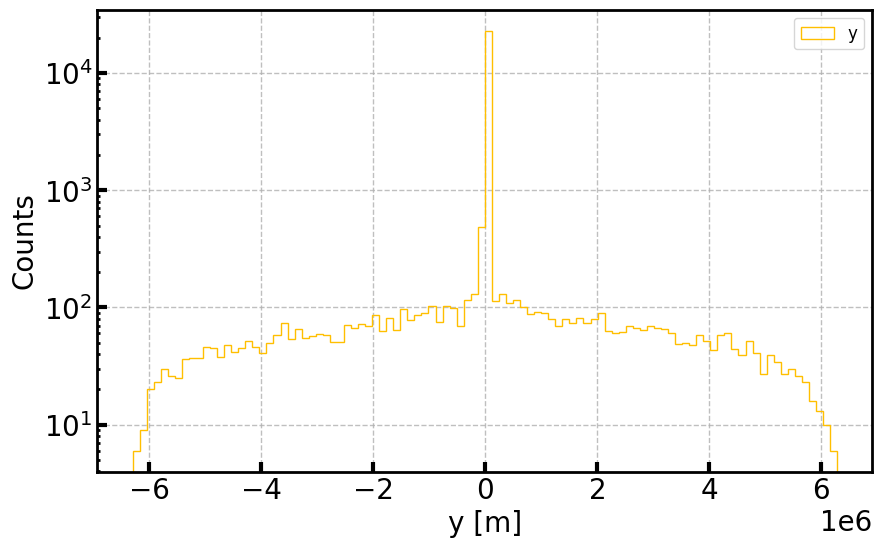

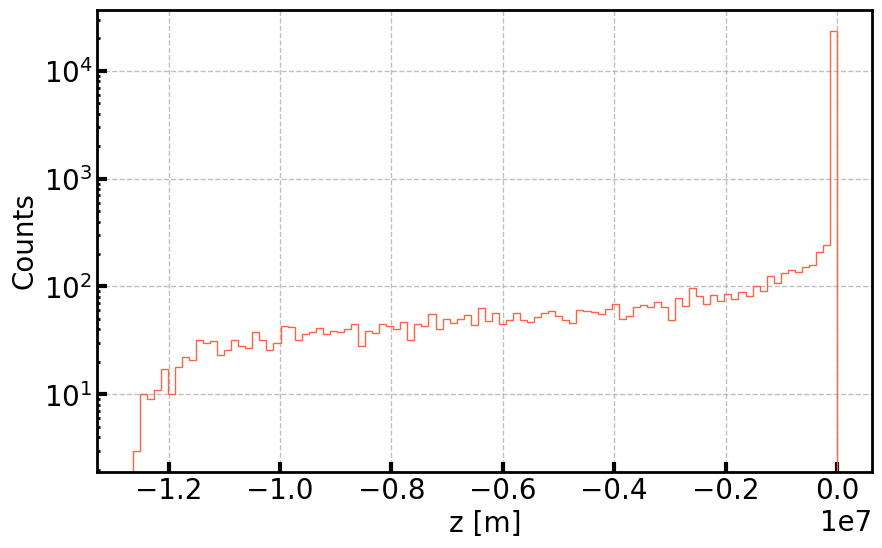

In [19]:
plot_pos_distribution(df_snowstorm_22012_part_1_GN_daughter['pos_x_GNHighestEDaughter'], df_snowstorm_22012_part_1_GN_daughter['pos_y_GNHighestEDaughter'], df_snowstorm_22012_part_1_GN_daughter['pos_z_GNHighestEDaughter'])

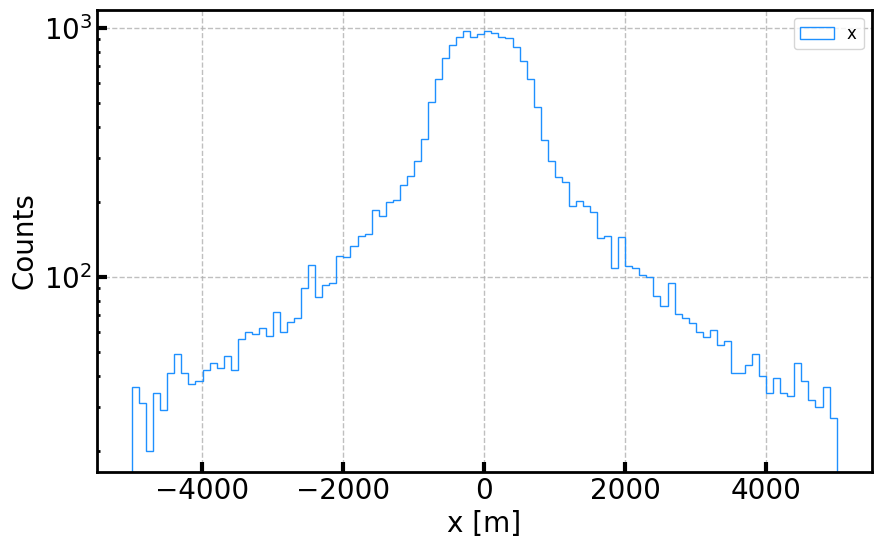

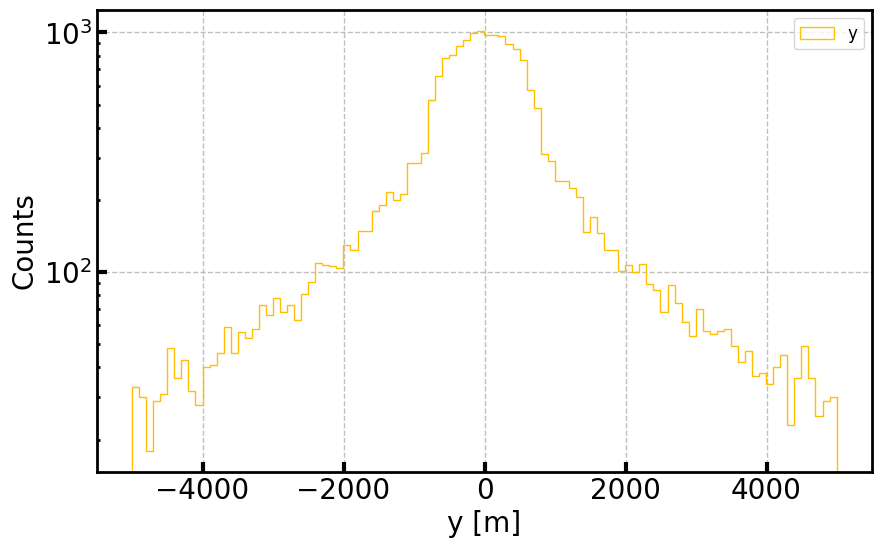

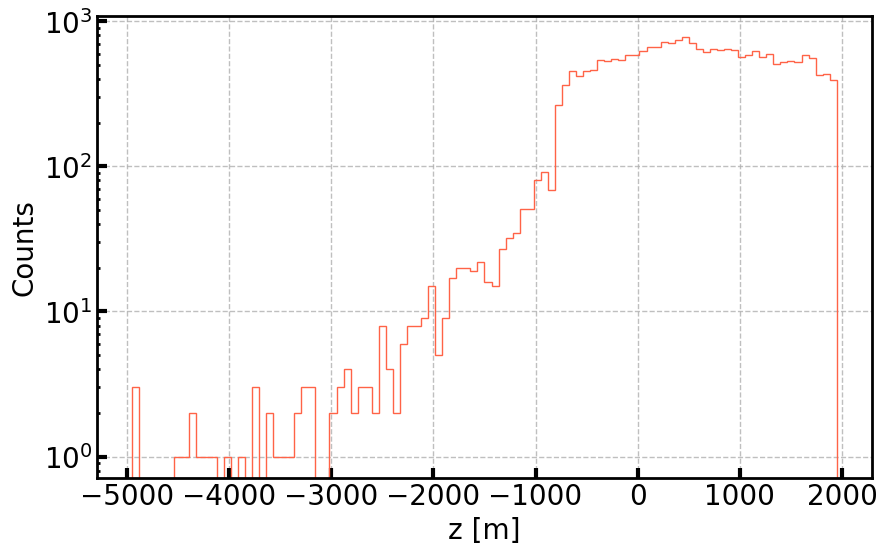

In [18]:
plot_pos_distribution(pos_x, pos_y, pos_z)